# Analysis of K-folds results

In [2]:
import pandas as pd
import os
import os.path
import torchaudio
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import Audio, display
import numpy as np
import math
import statistics
import time
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model, Wav2Vec2ForCTC, Wav2Vec2Tokenizer, AutoModelForCTC, Wav2Vec2Processor
import seaborn as sns
from itertools import chain
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

from CustomDatasets import CustomDataset1, CustomDataset2
from mergesplits import mergesplits
from padding import padding
from DatasetSplit import split_audios
from SaveData import splitpad_simple
from wav2vecClassifier_librispeech import Wav2Vec2Classifier_librispeech

/tmp/ipykernel_2842/3941269426.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/julieesc/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Function to get average, best and worst evaluation metric from test results
def averages(base, metric):
    mets = []
    best_fold = 0
    best_epoch = 0
    best_met = 0.0
    worst_fold = 0
    worst_epoch = 0
    worst_met = 1.0

    for i in range(1,11):
        df = pd.read_csv(os.path.join(base, f'test_results_fold_{i}.csv'))
        for idx, row in df.iterrows():
            if idx < 15:
                m = float(row[metric])
                if not math.isnan(m):
                    mets.append(m)
                    if m > best_met: 
                        best_fold = i
                        best_epoch = idx + 1
                        best_met = m
                    if m < worst_met:
                        worst_fold = i
                        worst_epoch = idx + 1
                        worst_met = m
    average = statistics.mean(mets)
    std = statistics.stdev(mets)
    print(f'Average {metric} {average:.3f} +- {std:.3f}')
    print(f'  Best performance: fold {best_fold}, epoch {best_epoch}, {metric} {best_met:.3f}')
    print(f'  Worst performance: fold {worst_fold}, epoch {worst_epoch}, {metric} {worst_met:.3f}')
    
metrics = ['accuracy', 'sensitivity', 'specificity', 'precision', 'recall']
base = 'results/pcgita1_kfolds_16batch_ddk_librispeech'

for metric in metrics:
    averages(base, metric)

Average accuracy 0.730 +- 0.098
  Best performance: fold 3, epoch 6, accuracy 0.867
  Worst performance: fold 9, epoch 2, accuracy 0.483
Average sensitivity 0.838 +- 0.139
  Best performance: fold 1, epoch 1, sensitivity 1.000
  Worst performance: fold 9, epoch 1, sensitivity 0.000
Average specificity 0.622 +- 0.211
  Best performance: fold 8, epoch 1, specificity 1.000
  Worst performance: fold 1, epoch 1, specificity 0.000
Average precision 0.709 +- 0.106
  Best performance: fold 8, epoch 1, precision 1.000
  Worst performance: fold 9, epoch 2, precision 0.489
Average recall 0.838 +- 0.139
  Best performance: fold 1, epoch 1, recall 1.000
  Worst performance: fold 9, epoch 1, recall 0.000


In [5]:
# Validation results from each fold
base = 'results/pcgita1_kfolds_16batch_ddk_librispeech'
for i in range(1,11):
    df = pd.read_csv(os.path.join(base, f'fit_results_fold_{i}.csv'))
    accs = []
    best_acc = 0.0
    best_idx = 0
    for idx, row in df.iterrows():
        acc = float(row['validation_accuracy'])
        accs.append(acc)
        if acc > best_acc:
            best_acc = acc
            best_idx = idx + 1
    average = statistics.mean(accs)
    std = statistics.stdev(accs)
    print(f'FOLD {i}')
    print(f'   Average accuracy: {average:.3f} +- {std:.3f}')
    print(f'   Best performace: epoch {best_idx}: {best_acc:.3f} ')

FOLD 1
   Average accuracy: 0.632 +- 0.072
   Best performace: epoch 8: 0.722 
FOLD 2
   Average accuracy: 0.743 +- 0.096
   Best performace: epoch 14: 0.813 
FOLD 3
   Average accuracy: 0.771 +- 0.063
   Best performace: epoch 10: 0.804 
FOLD 4
   Average accuracy: 0.745 +- 0.035
   Best performace: epoch 12: 0.787 
FOLD 5
   Average accuracy: 0.785 +- 0.058
   Best performace: epoch 15: 0.843 
FOLD 6
   Average accuracy: 0.773 +- 0.049
   Best performace: epoch 8: 0.811 
FOLD 7
   Average accuracy: 0.583 +- 0.020
   Best performace: epoch 7: 0.614 
FOLD 8
   Average accuracy: 0.580 +- 0.063
   Best performace: epoch 10: 0.655 
FOLD 9
   Average accuracy: 0.675 +- 0.060
   Best performace: epoch 15: 0.738 
FOLD 10
   Average accuracy: 0.620 +- 0.019
   Best performace: epoch 14: 0.651 


In [8]:
# Accuracy distributions
acc40 = []
acc50 = []
acc60 = []
acc70 = []
acc80 = []
acc90 = []
base = 'results/pcgita1_kfolds_16batch_ddk_librispeech'
for i in range(1,11):
    df = pd.read_csv(os.path.join(base, f'test_results_fold_{i}.csv'))
    accs = df['accuracy'].tolist()
    for a in accs:
        if a < 0.5:
            acc40.append(a)
        elif a < 0.6:
            acc50.append(a)
        elif a < 0.7:
            acc60.append(a)
        elif a < 0.8:
            acc70.append(a)
        elif a < 0.9:
            acc80.append(a)
        elif a < 1.0:
            acc90.append(a)

print(f'Between 40\% and 50\%: {len(acc40)}')
print(f'Between 50\% and 60\%: {len(acc50)}')
print(f'Between 60\% and 70\%: {len(acc60)}')
print(f'Between 70\% and 80\%: {len(acc70)}')
print(f'Between 80\% and 90\%: {len(acc80)}')
print(f'Between 90\% and 100\%: {len(acc90)}')

Between 40\% and 50\%: 1
Between 50\% and 60\%: 17
Between 60\% and 70\%: 21
Between 70\% and 80\%: 66
Between 80\% and 90\%: 45
Between 90\% and 100\%: 0


In [9]:
# Get evaluation metrics and confusion matrix data from a specific result
df = pd.read_csv('results/pcgita1_kfolds_16batch_ddk_librispeech/test_classifications_fold_3_epoch_6.csv')

label = []
pred = []

for idx, row in df.iterrows():
    l = int(row['label'])
    p = int(row['predicted'])
    label.append(l)
    pred.append(p)

TP = sum(1 for pred, lab in zip(pred, label) if pred == 1 and lab == 1)
TN = sum(1 for pred, lab in zip(pred, label) if pred == 0 and lab == 0)
FP = sum(1 for pred, lab in zip(pred, label) if pred == 1 and lab == 0)
FN = sum(1 for pred, lab in zip(pred, label) if pred == 0 and lab == 1)

print(f'TP={TP}, TN={TN}, FP={FP}, FN={FN}')

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f'accuracy {accuracy:.3f}, sensitivity {sensitivity:.3f}, specificity {specificity:.3f}, precision {precision:.3f}, recall {recall:.3f}')

TP=24, TN=28, FP=2, FN=6
accuracy 0.867, sensitivity 0.800, specificity 0.933, precision 0.923, recall 0.800


In [10]:
# Get average losses

base = 'results/pcgita1_kfolds_16batch_ddk_librispeech'

losses = [[] for _ in range(15)]
for i in range(1,11):
    df = pd.read_csv(os.path.join(base, f'fit_results_fold_{i}.csv'))
    loss = df['training_loss'].tolist()
    for i, l in enumerate(loss):
        losses[i].append(l)
    #f1 = df.loc[df['epoch'] == 1, 'training_loss'].values[0]
    #f10 = df.loc[df['epoch'] == 10, 'training_loss'].values[0]
for i, l in enumerate(losses):
    losses[i] = statistics.mean(losses[i])
print(f'Training losses: {losses}')

losses = [[] for _ in range(15)]
for i in range(1,11):
    df = pd.read_csv(os.path.join(base, f'fit_results_fold_{i}.csv'))
    loss = df['validation_loss'].tolist()
    for i, l in enumerate(loss):
        losses[i].append(l)
for i, l in enumerate(losses):
    losses[i] = statistics.mean(losses[i])
print(f'\nValidation losses: {losses}')

Training losses: [0.7096194641165352, 0.6362024299169454, 0.6020273641854351, 0.5860697135963955, 0.5755178990182535, 0.5695778748052196, 0.5623289462055155, 0.5582248280350192, 0.5548827993228572, 0.5501929426479788, 0.5486764478967168, 0.5468484682015341, 0.5437242502129432, 0.5424505353636793, 0.5403788287168103]

Validation losses: [0.6866324178708925, 0.6513527196645736, 0.6374260787831413, 0.6336480842034022, 0.6302817702458965, 0.6282411299149195, 0.6278501096864542, 0.6261787810424964, 0.6243349257773824, 0.6228155359460248, 0.6222126313712861, 0.6198235017392371, 0.6204596999122037, 0.6226551951467991, 0.6230958001481162]


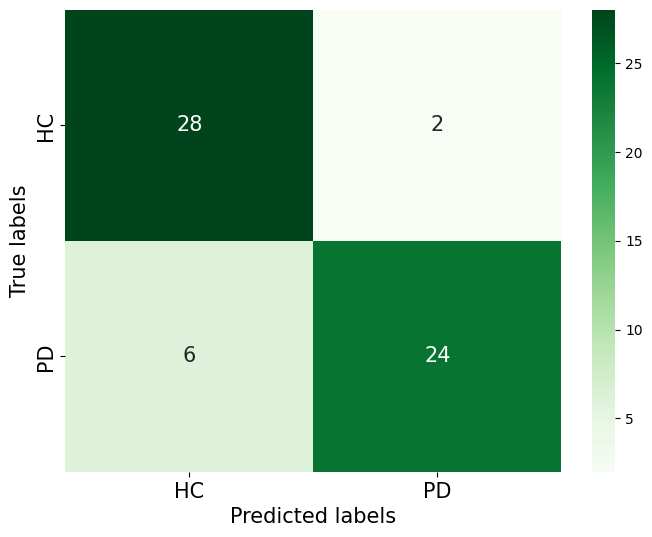

In [11]:
# Plot confusion matrix
df = pd.read_csv('results/pcgita1_kfolds_16batch_ddk_librispeech/test_classifications_fold_3_epoch_6.csv')

label = df['label'].tolist()
pred = df['predicted'].tolist()

cm = confusion_matrix(label, pred)

f = plt.figure(figsize=(8,6))
ax= f.add_subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Greens', annot_kws={"size": 15})
ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('True labels', fontsize=15)
ax.xaxis.set_ticklabels(['HC', 'PD'], fontsize=15)
ax.yaxis.set_ticklabels(['HC', 'PD'], fontsize=15)
plt.show()

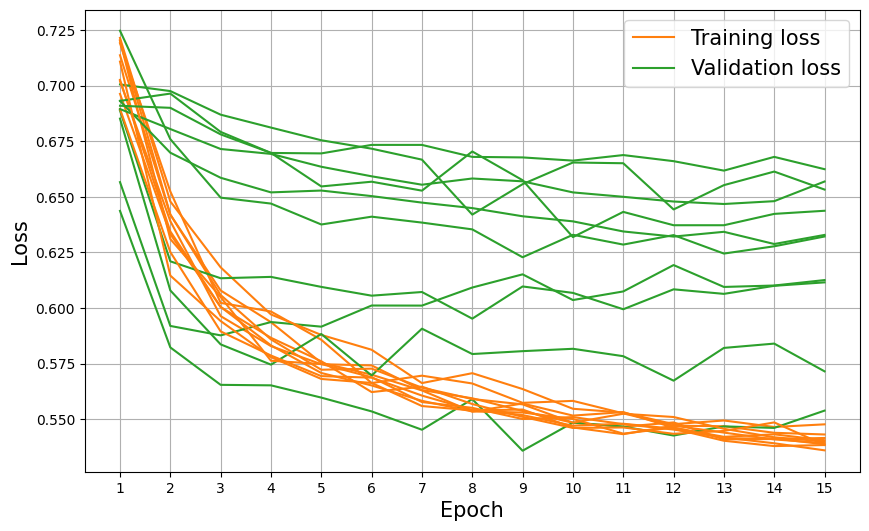

In [13]:
# Loss curves over all folds
base = 'results/pcgita1_kfolds_16batch_ddk_librispeech'

plt.figure(figsize=(10, 6))

for k in range(1,11):
    fit = os.path.join(base, f'fit_results_fold_{k}.csv')
    df = pd.read_csv(fit)
    train = df['training_loss'].tolist()
    val = df['validation_loss'].tolist()
    v = [i for i in range(1,16)]

    if k == 1:
        plt.plot(v, train, label='Training loss', color='C1')
        plt.plot(v, val, label='Validation loss', color='#2ca02c')

    else:
        plt.plot(v, train, color='C1')
        plt.plot(v, val, color='#2ca02c')

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xticks(range(1, 16))
plt.grid()
plt.legend(fontsize=15)
plt.show()

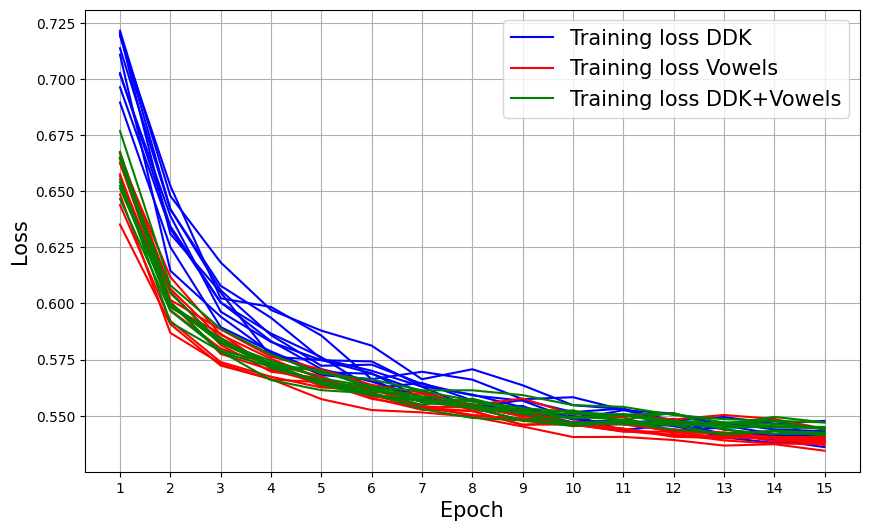

"\nlosscurves_pcgita_libri\nelif k == 10:\n    plt.plot(v, train, label='Best Train loss', color='#2ca02c')\n    plt.plot(v, val, label='Best Validation loss', color='#bcbd22')\n"

In [14]:
# Training loss curves for 3 models

plt.figure(figsize=(10, 6))

base = 'results/pcgita1_kfolds_16batch_ddk_librispeech'
for k in range(1,11):
    fit = os.path.join(base, f'fit_results_fold_{k}.csv')
    df = pd.read_csv(fit)
    train = df['training_loss'].tolist()
    val = df['validation_loss'].tolist()
    v = [i for i in range(1,16)]

    if k == 1:
        plt.plot(v, train, label='Training loss DDK', color='blue')
        #plt.plot(v, val, label='Validation loss', color='#2ca02c')
    else:
        plt.plot(v, train, color='blue')
        #plt.plot(v, val, color='#2ca02c')

base = 'results/pcgita1_kfolds_16batch_vowels_modulated_librispeech'
for k in range(1,11):
    fit = os.path.join(base, f'fit_results_fold_{k}.csv')
    df = pd.read_csv(fit)
    train = df['training_loss'].tolist()
    val = df['validation_loss'].tolist()
    v = [i for i in range(1,16)]

    if k == 1:
        plt.plot(v, train, label='Training loss Vowels', color='red')
        #plt.plot(v, val, label='Validation loss', color='#2ca02c')
    else:
        plt.plot(v, train, color='red')
        #plt.plot(v, val, color='#2ca02c')

base = 'results/pcgita1_kfolds_16batch_ddk_vowels_modulated_librispeech'
for k in range(1,11):
    fit = os.path.join(base, f'fit_results_fold_{k}.csv')
    df = pd.read_csv(fit)
    train = df['training_loss'].tolist()
    val = df['validation_loss'].tolist()
    v = [i for i in range(1,16)]

    if k == 1:
        plt.plot(v, train, label='Training loss DDK+Vowels', color='green')
        #plt.plot(v, val, label='Validation loss', color='#2ca02c')
    else:
        plt.plot(v, train, color='green')
        #plt.plot(v, val, color='#2ca02c')

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
#plt.title(f'Loss curves EWA-DB CommonVoice of 10 folds', fontsize=15)
plt.xticks(range(1, 16))
#plt.yticks(range(0.5,1.4,0.1))
plt.grid()
plt.legend(fontsize=15)
plt.show()

'''
losscurves_pcgita_libri
elif k == 10:
    plt.plot(v, train, label='Best Train loss', color='#2ca02c')
    plt.plot(v, val, label='Best Validation loss', color='#bcbd22')
'''

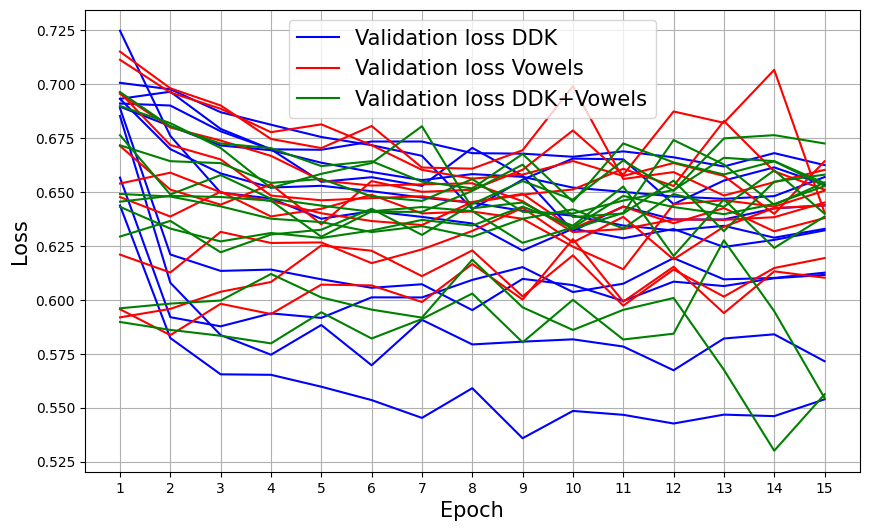

"\nlosscurves_pcgita_libri\nelif k == 10:\n    plt.plot(v, train, label='Best Train loss', color='#2ca02c')\n    plt.plot(v, val, label='Best Validation loss', color='#bcbd22')\n"

In [15]:
# Validation loss curves for 3 models

plt.figure(figsize=(10, 6))

base = 'results/pcgita1_kfolds_16batch_ddk_librispeech'
for k in range(1,11):
    fit = os.path.join(base, f'fit_results_fold_{k}.csv')
    df = pd.read_csv(fit)
    train = df['training_loss'].tolist()
    val = df['validation_loss'].tolist()
    v = [i for i in range(1,16)]

    if k == 1:
        #plt.plot(v, train, label='Training loss DDK', color='blue')
        plt.plot(v, val, label='Validation loss DDK', color='blue')
    else:
        plt.plot(v, val, color='blue')

base = 'results/pcgita1_kfolds_16batch_vowels_modulated_librispeech'
for k in range(1,11):
    fit = os.path.join(base, f'fit_results_fold_{k}.csv')
    df = pd.read_csv(fit)
    train = df['training_loss'].tolist()
    val = df['validation_loss'].tolist()
    v = [i for i in range(1,16)]

    if k == 1:
        #plt.plot(v, train, label='Training loss Vowels', color='red')
        plt.plot(v, val, label='Validation loss Vowels', color='red')
    else:
        plt.plot(v, val, color='red')

base = 'results/pcgita1_kfolds_16batch_ddk_vowels_modulated_librispeech'
for k in range(1,11):
    fit = os.path.join(base, f'fit_results_fold_{k}.csv')
    df = pd.read_csv(fit)
    train = df['training_loss'].tolist()
    val = df['validation_loss'].tolist()
    v = [i for i in range(1,16)]

    if k == 1:
        #plt.plot(v, train, label='Training loss DDK+Vowels', color='green')
        plt.plot(v, val, label='Validation loss DDK+Vowels', color='green')
    else:
        plt.plot(v, val, color='green')

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
#plt.title(f'Loss curves EWA-DB CommonVoice of 10 folds', fontsize=15)
plt.xticks(range(1, 16))
#plt.yticks(range(0.5,1.4,0.1))
plt.grid()
plt.legend(fontsize=15)
plt.show()

'''
losscurves_pcgita_libri
elif k == 10:
    plt.plot(v, train, label='Best Train loss', color='#2ca02c')
    plt.plot(v, val, label='Best Validation loss', color='#bcbd22')
'''

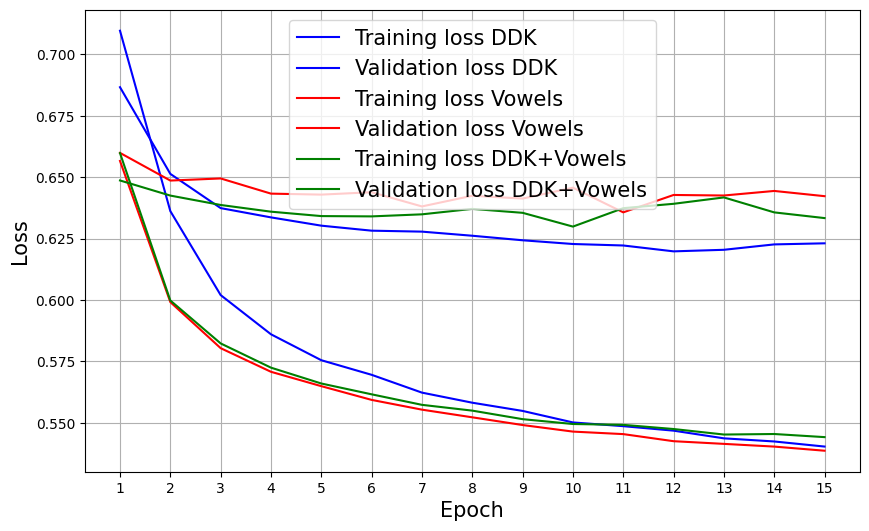

In [16]:
# Average losses for 3 models

def get_avg(base):
    trains = [[] for _ in range(15)]
    for i in range(1,11):
        df = pd.read_csv(os.path.join(base, f'fit_results_fold_{i}.csv'))
        loss = df['training_loss'].tolist()
        for i, l in enumerate(loss):
            trains[i].append(l)
    for i, l in enumerate(trains):
        trains[i] = statistics.mean(trains[i])
    
    vals = [[] for _ in range(15)]
    for i in range(1,11):
        df = pd.read_csv(os.path.join(base, f'fit_results_fold_{i}.csv'))
        loss = df['validation_loss'].tolist()
        for i, l in enumerate(loss):
            vals[i].append(l)
    for i, l in enumerate(vals):
        vals[i] = statistics.mean(vals[i])
    return trains, vals


plt.figure(figsize=(10, 6))
v = [i for i in range(1,16)]

base = 'results/pcgita1_kfolds_16batch_ddk_librispeech'
trains, vals = get_avg(base)
plt.plot(v, trains, label='Training loss DDK', color='blue')
plt.plot(v, vals, label='Validation loss DDK', color='blue')

base = 'results/pcgita1_kfolds_16batch_vowels_modulated_librispeech'
trains, vals = get_avg(base)
plt.plot(v, trains, label='Training loss Vowels', color='red')
plt.plot(v, vals, label='Validation loss Vowels', color='red')


base = 'results/pcgita1_kfolds_16batch_ddk_vowels_modulated_librispeech'
trains, vals = get_avg(base)
plt.plot(v, trains, label='Training loss DDK+Vowels', color='green')
plt.plot(v, vals, label='Validation loss DDK+Vowels', color='green')

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
#plt.title(f'Loss curves EWA-DB CommonVoice of 10 folds', fontsize=15)
plt.xticks(range(1, 16))
#plt.yticks(range(0.5,1.4,0.1))
plt.grid()
plt.legend(fontsize=15)
plt.show()

In [17]:
# Detailed test results
df = pd.read_csv('results/pcgita1_kfolds_16batch_ddk_librispeech/test_classifications_fold_3_epoch_6.csv')
#types = ['naming', 'pataka', 'phonation', 'picture'] # EWADB
types = ['DDK_analysis', 'Vowels', 'Words', 'modulated_vowels', 'monologue', 'read_text', 'sentences'] # PCGITA

ids_miss = []
paths_miss = []
labels_miss = []
preds_miss = []

ids_all = []
paths_all = []
labels_all = []
preds_all = []

for idx, row in df.iterrows():
    pred = row['predicted']
    label = row['label']
    path = row['path']
    #id = path.split('/')[-3] # EWADB
    id = path.split('/')[-1].split('_')[0] # PCGITA

    ids_all.append(id)
    paths_all.append(path)
    labels_all.append(label)
    preds_all.append(pred)
    
    if pred != label:
        ids_miss.append(id)
        paths_miss.append(path)
        labels_miss.append(label)
        preds_miss.append(pred)
    

###### IDS ######
ids0 = []
count0 = []
occurrences = Counter(ids_miss)
for value, count in occurrences.items():
    ids0.append(value)
    count0.append(count)
    #print(f"{value}: {count} occurrences")
ids1 = []
count1 = []
occurrences = Counter(ids_all)
for value, count in occurrences.items():
    ids1.append(value)
    count1.append(count)
    #print(f"{value}: {count} occurrences")
for idx, i in enumerate(ids1):
    c0 = count0[ids0.index(i)] if i in ids0 else 0
    print(f'{i}: {c0} miss of {count1[idx]}')

###### TYPES ######
print('\n')
for folder in types:
    miss = sum(1 for file in paths_miss if folder in file)
    tot = sum(1 for file in paths_all if folder in file)
    print(f'{folder}: {miss} miss of {tot}')

###### FILES ######
print('\n')
for i, v in enumerate(ids_miss):
    print(f'ID: {v}, label: {labels_miss[i]}, pred: {preds_miss[i]}')
    print(paths_miss[i])
    display(Audio(data=paths_miss[i], rate = 16000, autoplay=False))
    print('---')

AVPEPUDEAC0012: 0 miss of 6
AVPEPUDEAC0016: 1 miss of 6
AVPEPUDEAC0034: 0 miss of 6
AVPEPUDEAC0042: 0 miss of 6
AVPEPUDEAC0051: 1 miss of 6
AVPEPUDEA0002: 0 miss of 6
AVPEPUDEA0006: 1 miss of 6
AVPEPUDEA0008: 5 miss of 6
AVPEPUDEA0046: 0 miss of 6
AVPEPUDEA0057: 0 miss of 6


DDK_analysis: 8 miss of 60
Vowels: 0 miss of 0
Words: 0 miss of 0
modulated_vowels: 0 miss of 0
monologue: 0 miss of 0
read_text: 0 miss of 0
sentences: 0 miss of 0


ID: AVPEPUDEA0008, label: 1, pred: 0
../../../talebase/data/speech_raw/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/pd/AVPEPUDEA0008_ka.wav


---
ID: AVPEPUDEA0006, label: 1, pred: 0
../../../talebase/data/speech_raw/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/pa-pa-pa/sin_normalizar/pd/AVPEPUDEA0006_pa.wav


---
ID: AVPEPUDEA0008, label: 1, pred: 0
../../../talebase/data/speech_raw/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/pa-pa-pa/sin_normalizar/pd/AVPEPUDEA0008_pa.wav


---
ID: AVPEPUDEA0008, label: 1, pred: 0
../../../talebase/data/speech_raw/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/pakata/sin_normalizar/pd/AVPEPUDEA0008_pakata.wav


---
ID: AVPEPUDEA0008, label: 1, pred: 0
../../../talebase/data/speech_raw/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/pataka/sin_normalizar/PD/AVPEPUDEA0008_pataka.wav


---
ID: AVPEPUDEAC0051, label: 0, pred: 1
../../../talebase/data/speech_raw/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/petaka/sin_normalizar/hc/AVPEPUDEAC0051_petaka.wav


---
ID: AVPEPUDEAC0016, label: 0, pred: 1
../../../talebase/data/speech_raw/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ta-ta-ta/sin_normalizar/hc/AVPEPUDEAC0016_ta.wav


---
ID: AVPEPUDEA0008, label: 1, pred: 0
../../../talebase/data/speech_raw/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ta-ta-ta/sin_normalizar/pd/AVPEPUDEA0008_ta.wav


---
